# 0.0 IMPORTS

In [1]:
import math
import pandas as pd
import numpy as np
import inflection
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from scipy                 import stats as ss
from matplotlib.gridspec   import GridSpec
from boruta                import BorutaPy
from IPython.core.display  import HTML
from IPython.display       import Image


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import datetime
from tabulate import tabulate

## 0.1. Helper Functions

In [73]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.4f' % x)

    sns.set()
jupyter_settings()

def cramer_v(x, y):
    """measure of association between two nominal variables, made by user"""
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    phi2 = chi2/n
    min_d = min(k-1, r-1)
    
    V = np.sqrt(phi2 / (min_d))
    
    
    phi2corr = max(0, phi2 - ((k-1)*(r-1)/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    min_dcorr = min(kcorr-1, rcorr-1)
    
    Vcorr = np.sqrt(phi2corr / (min_dcorr))
    
    return Vcorr

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({   'Model Name': model_name,'MAE': mae,'MAPE': mape,'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose == True:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list ), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list ), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list ), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str) }, index=[0])

## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))


# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

In [10]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
# miss_val = pd.DataFrame(data=df1.isnull().sum().sort_values(ascending=False), columns=['MissValCount'])
# miss_val

# # Add a new column to the DataFrame and fill it with the percentage of missing values
# miss_val['Percent'] = miss_val['MissValCount'].apply(lambda x: '{:.2f}'.format(float(x)/df1.shape[0]*100))
# miss_val = miss_val[miss_val['MissValCount'] > 0]
# miss_val

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
689677,278,1,2013-10-21,8490,920,1,1,0,0,a,c,9260.0000,2.0000,2010.0000,0,nan,nan,NaN


In [14]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if pd.isna(x) else x)


# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


# competition_open_since_year

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


## 1.6. Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [19]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']


# num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T
# função do pandas

In [20]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0000,1115.0000,1114.0000,558.4297,558.0000,321.9085,-0.0010,-1.2005
1,day_of_week,1.0000,7.0000,6.0000,3.9983,4.0000,1.9974,0.0016,-1.2469
2,sales,0.0000,41551.0000,41551.0000,5773.8190,5744.0000,3849.9243,0.6415,1.7784
3,customers,0.0000,7388.0000,7388.0000,633.1459,609.0000,464.4115,1.5987,7.0918
4,open,0.0000,1.0000,1.0000,0.8301,1.0000,0.3755,-1.7580,1.0907
5,promo,0.0000,1.0000,1.0000,0.3815,0.0000,0.4858,0.4878,-1.7620
6,school_holiday,0.0000,1.0000,1.0000,0.1786,0.0000,0.3831,1.6778,0.8152
7,competition_distance,20.0000,200000.0000,199980.0000,5935.4427,2330.0000,12547.6468,10.2423,147.7897
8,competition_open_since_month,1.0000,12.0000,11.0000,6.7868,7.0000,3.3111,-0.0421,-1.2326
9,competition_open_since_year,1900.0000,2015.0000,115.0000,2010.3248,2012.0000,5.5156,-7.2357,124.0713


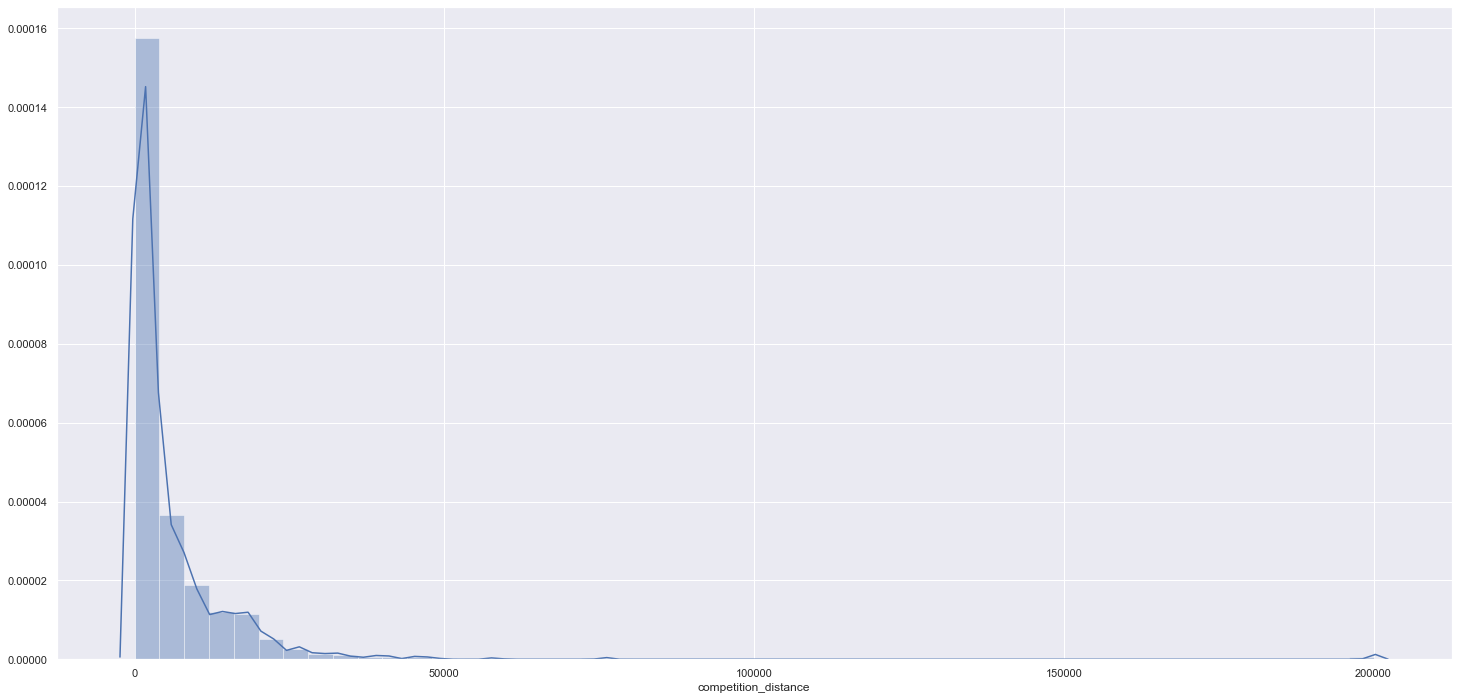

In [21]:
# plt.figure(figsize=[16,12])
sns.distplot(df1['competition_distance'])

plt.show()

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

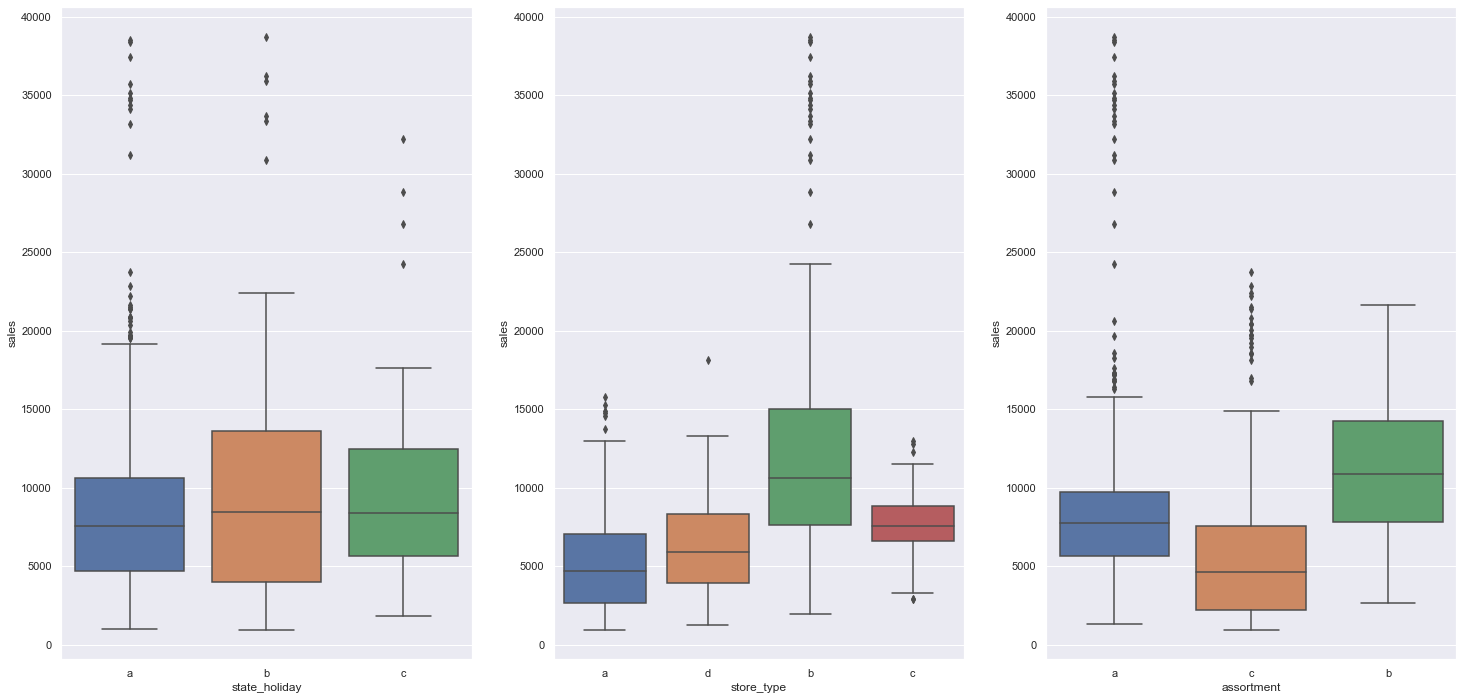

In [23]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)
plt.show()


# Lembrando que:
# "min" nao é o valor mìnimo e sim = Q1-1.5* (Q3-Q1)
# "max" nao é o valor màximo e sim = Q3+1.5 *(Q3-Q1)

# 2.0. FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

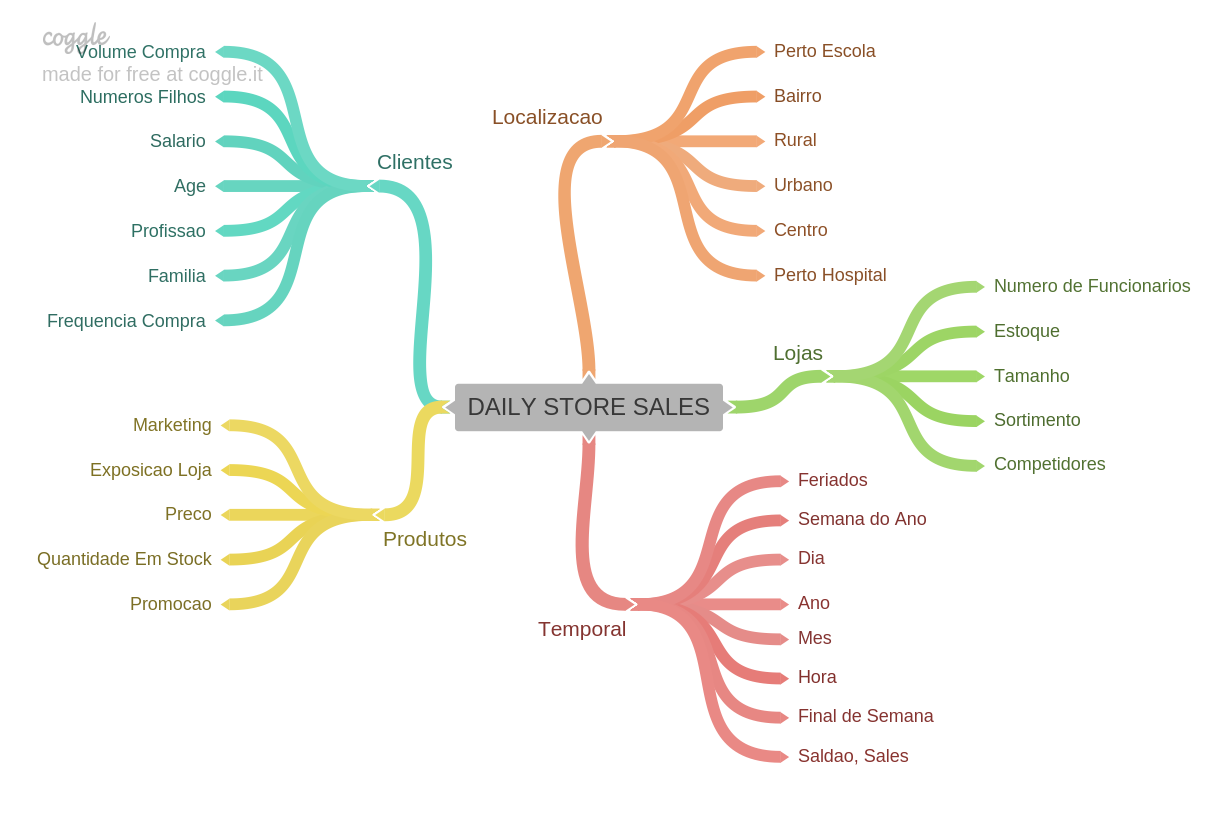

In [25]:
Image('img/MindMapHypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with more stock should sell more.

**3.** Larger stores should sell more.

**4.** Smaller stores should sell less.

**5.** Stores with greater assortment should sell more.

**6.** Stores with closer competitors should sell less.

**7.** Stores with longer competitors should sell more.

### 2.2.2. Product Hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores that display more of the product in their windows should sell more.

**3.** Stores that have lower prices should sell more.

**4.** Stores with longer active promotions should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

### 2.2.3 Time Hypothesis

**1.** Stores open during the Christmas holiday should sell more.
 
**2.** Stores should sell more over the years.
 
**3.** Stores should sell more in the second half of the year.
 
**4.** Stores should sell more after the 10th of each month.
 
**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3. Hypothesis Final List

**1.** Stores with greater assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with longer active promotions should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.
 
**8.** Stores should sell more over the years.
 
**9.** Stores should sell more in the second semester of the year.
 
**10.** Stores should sell more after the 10th day of each month.
 
**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.4. Feature Engineering

In [26]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since 
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = (((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days)).astype('int64')


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')



# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')

# 3.0. FEATURE FILTERING

In [27]:
df3 = df2.copy()

## 3.1. Row Filtering

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Column Selection

In [29]:
# nao iremos usar
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. EXPLORATORY DATA ANALYSIS

In [30]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

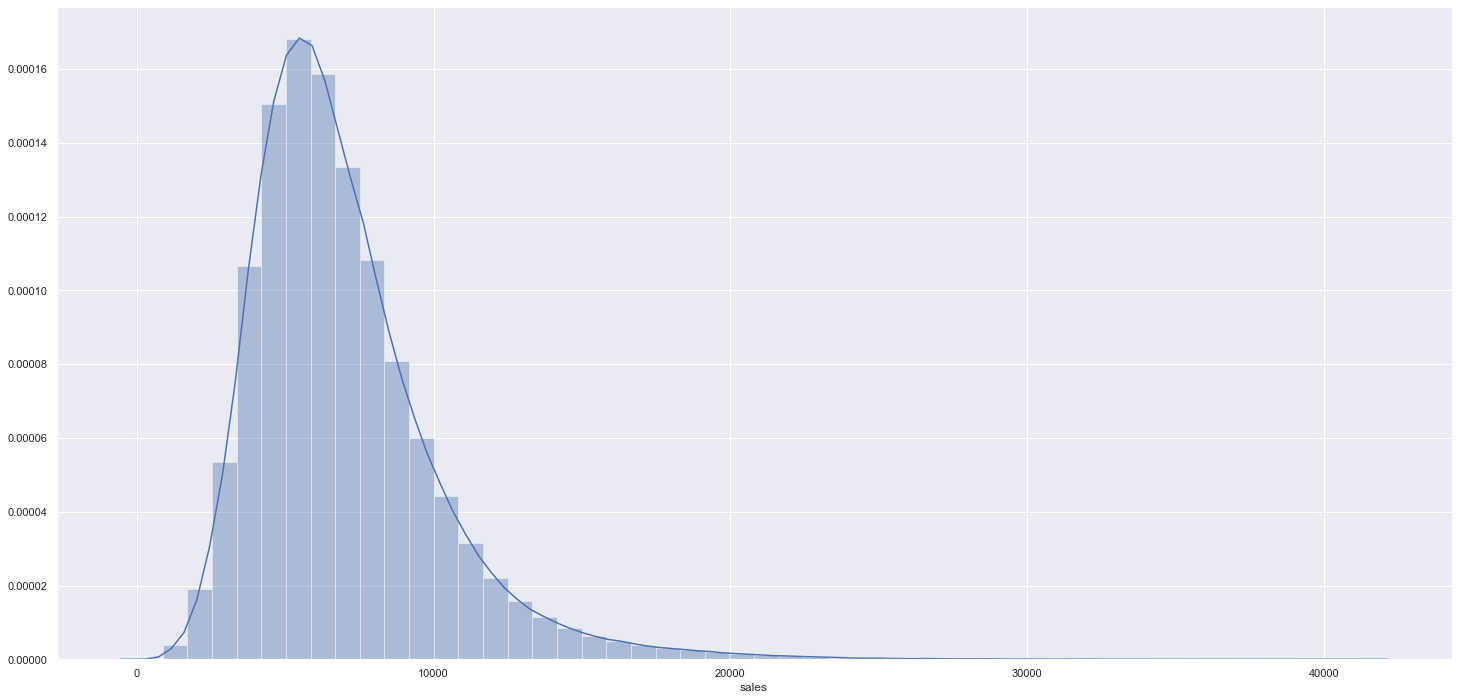

In [31]:
sns.distplot(df4['sales'])
# sns.distplot(df4['sales'], kde=False) # histograma


### 4.1.2. Numerical Variable

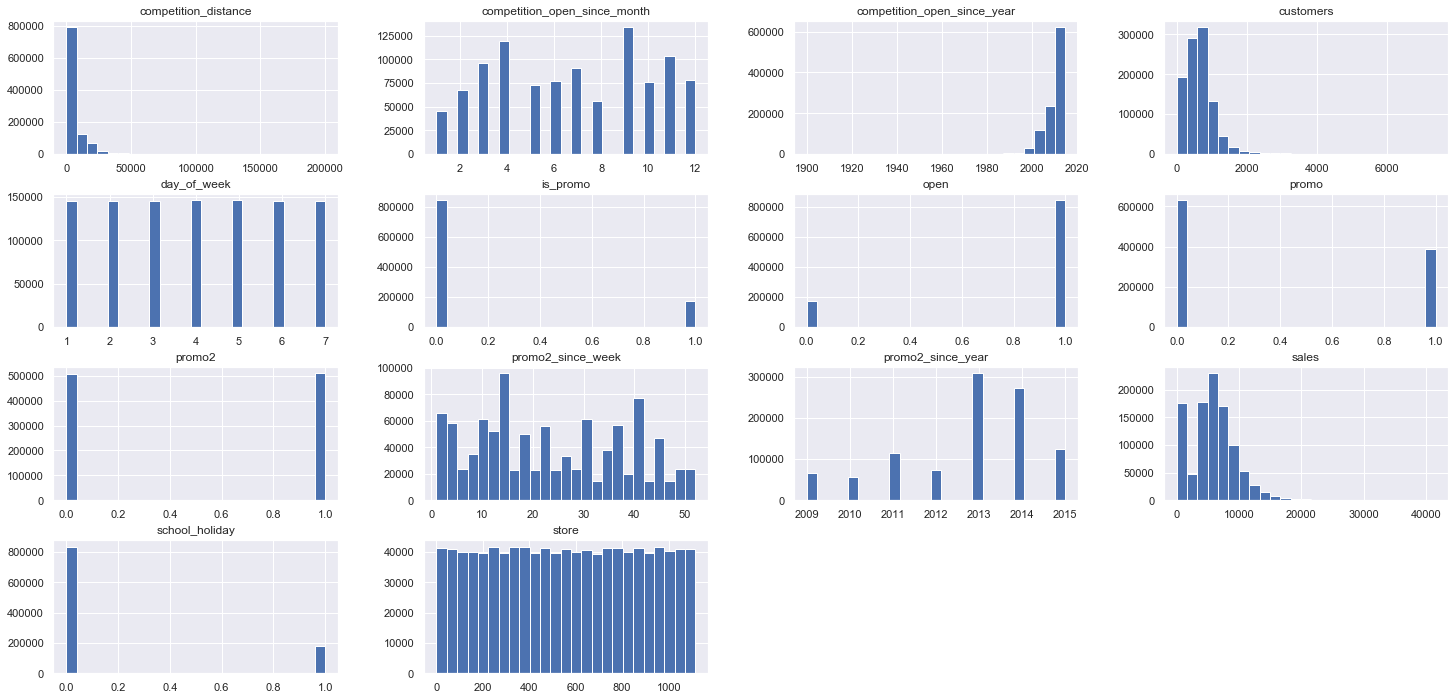

In [32]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [33]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


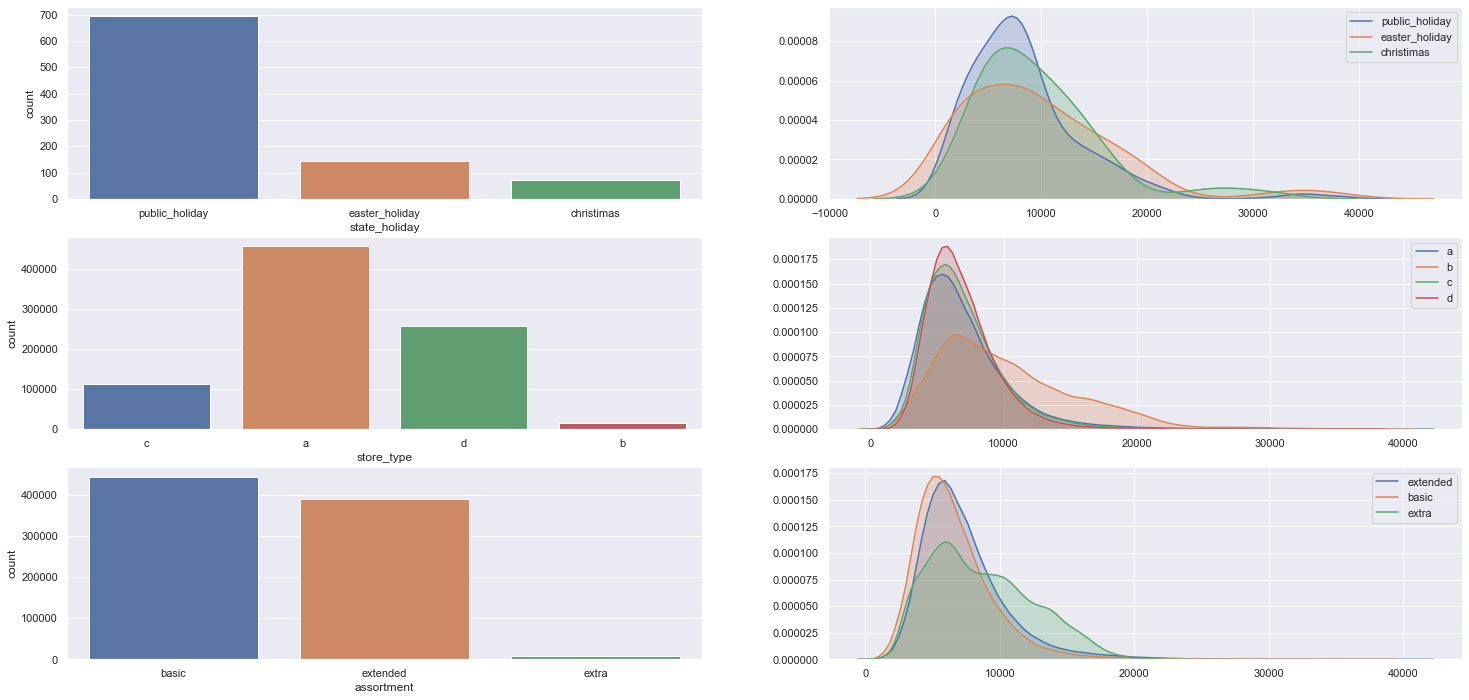

In [34]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christimas']['sales'], label='christimas', shade=True)



# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)



# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2. Bivariate Analysis

### **H1.** Stores with greater assortment should sell more.

**FALSE**: Stores with **greater assortment** sell **LESS**.


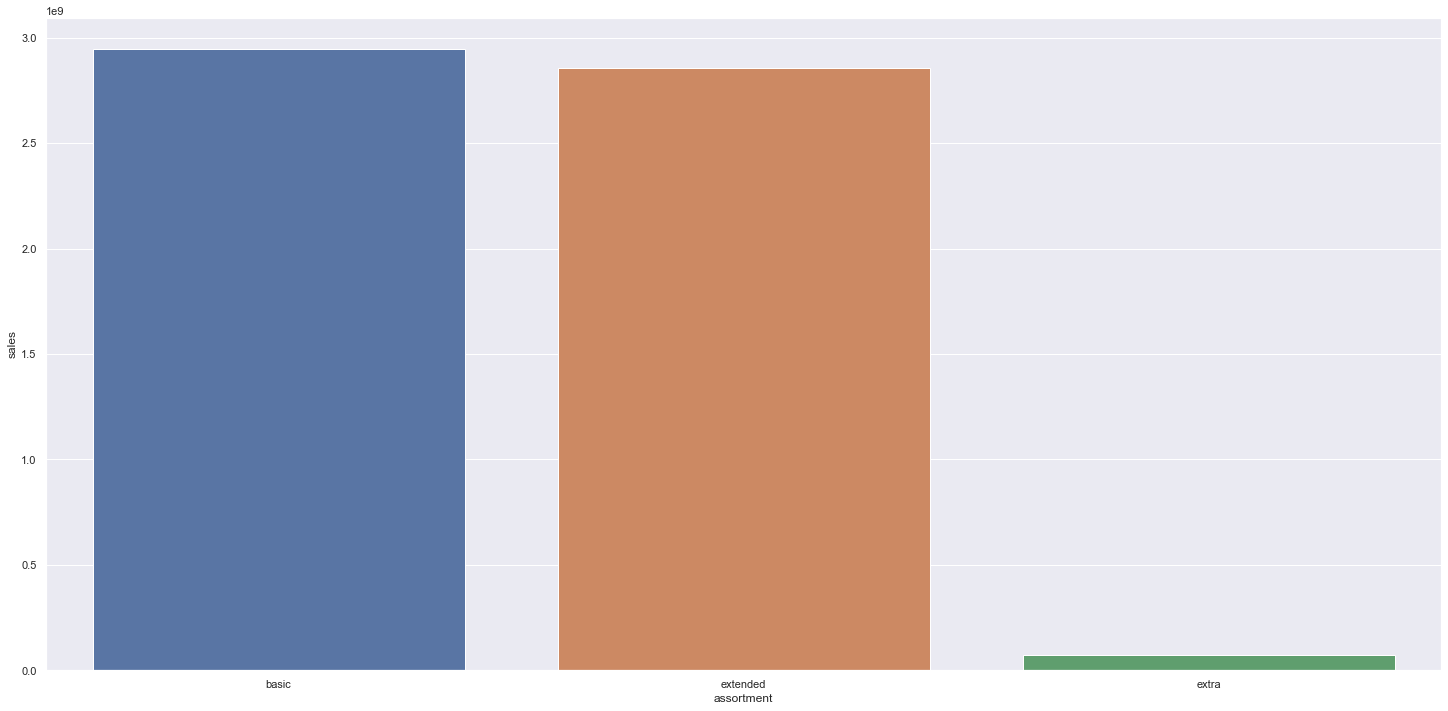

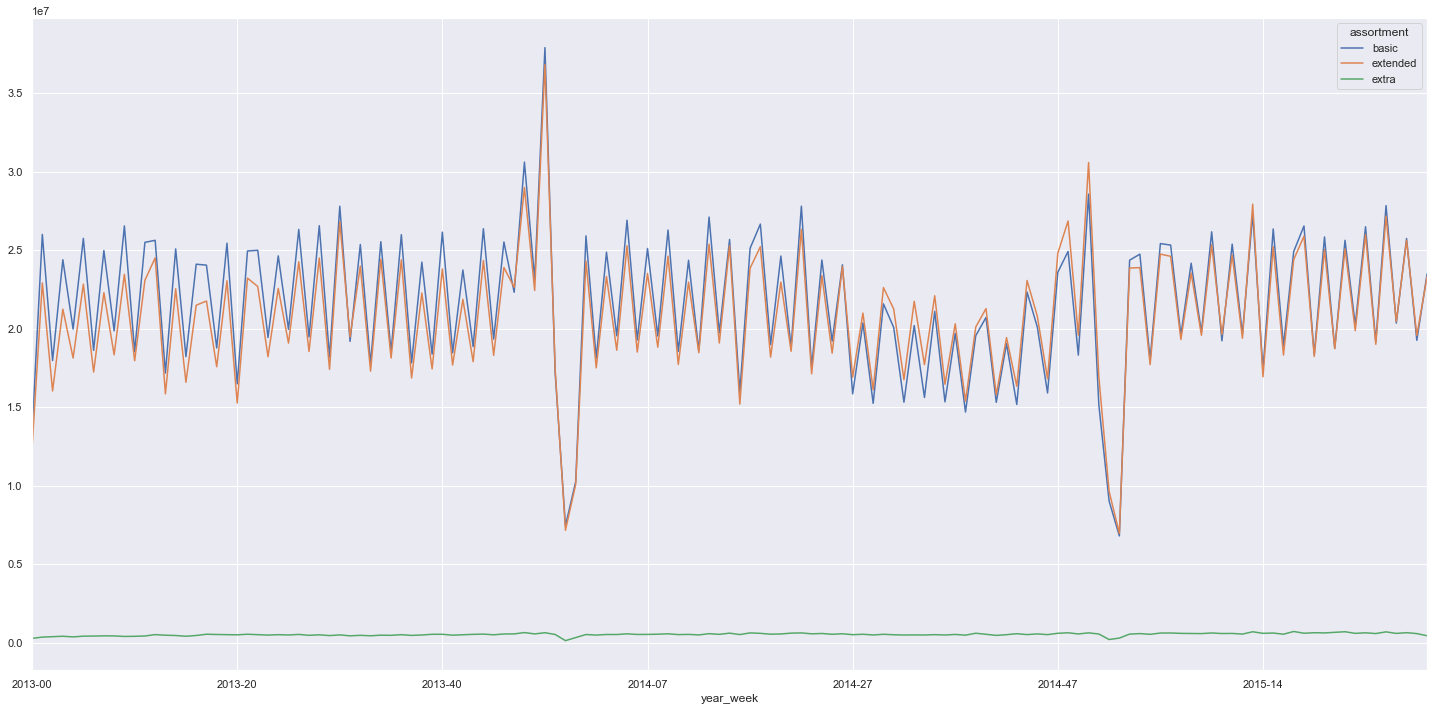

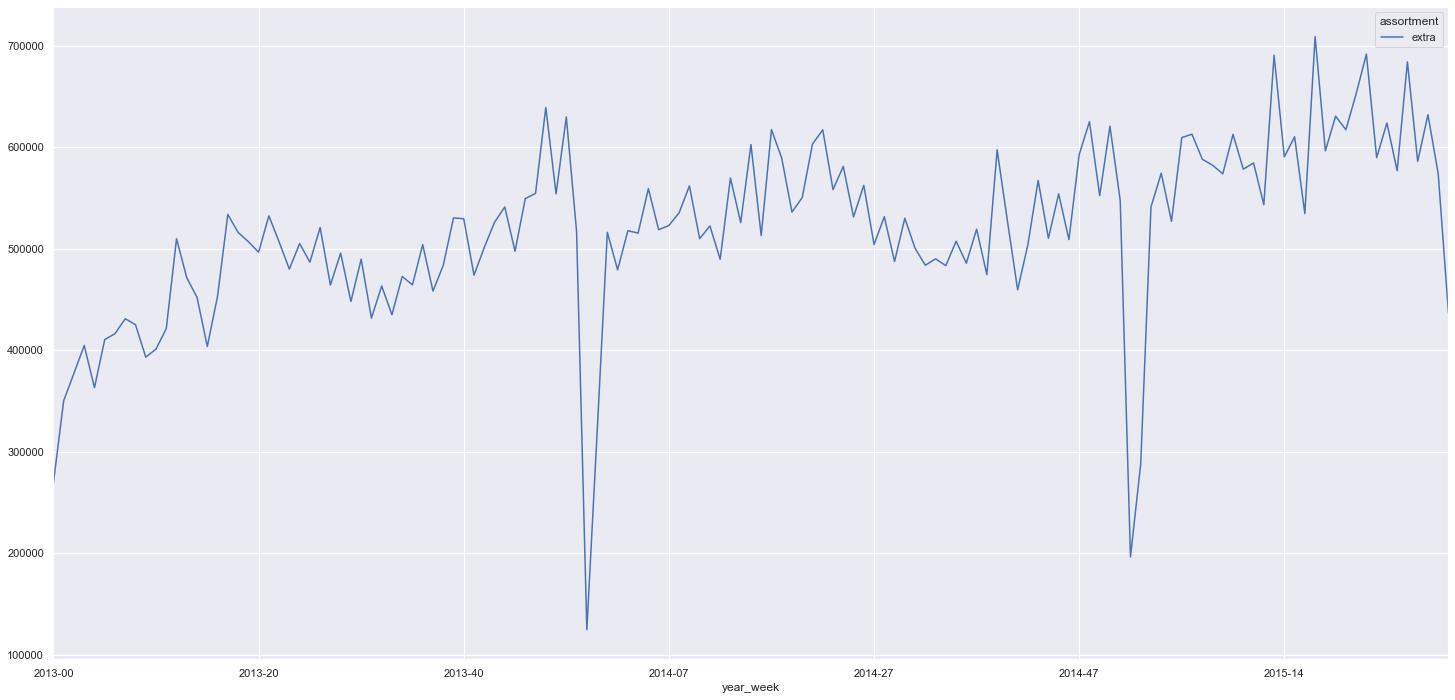

In [35]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

In [36]:
# Hipótese **Falsa**:
#     - Essa variavel será relevante para nosso modelo, pois apesar de 'basic' e 'extended' serem iguais, 'extra' apresenta um outro comportamento, tendo grandes variações de acordo com sua sazonalidade.

### **H2.** Stores with closer competitors should sell less.
**FALSE**: Stores with **closest competitors** sell **MORE**.

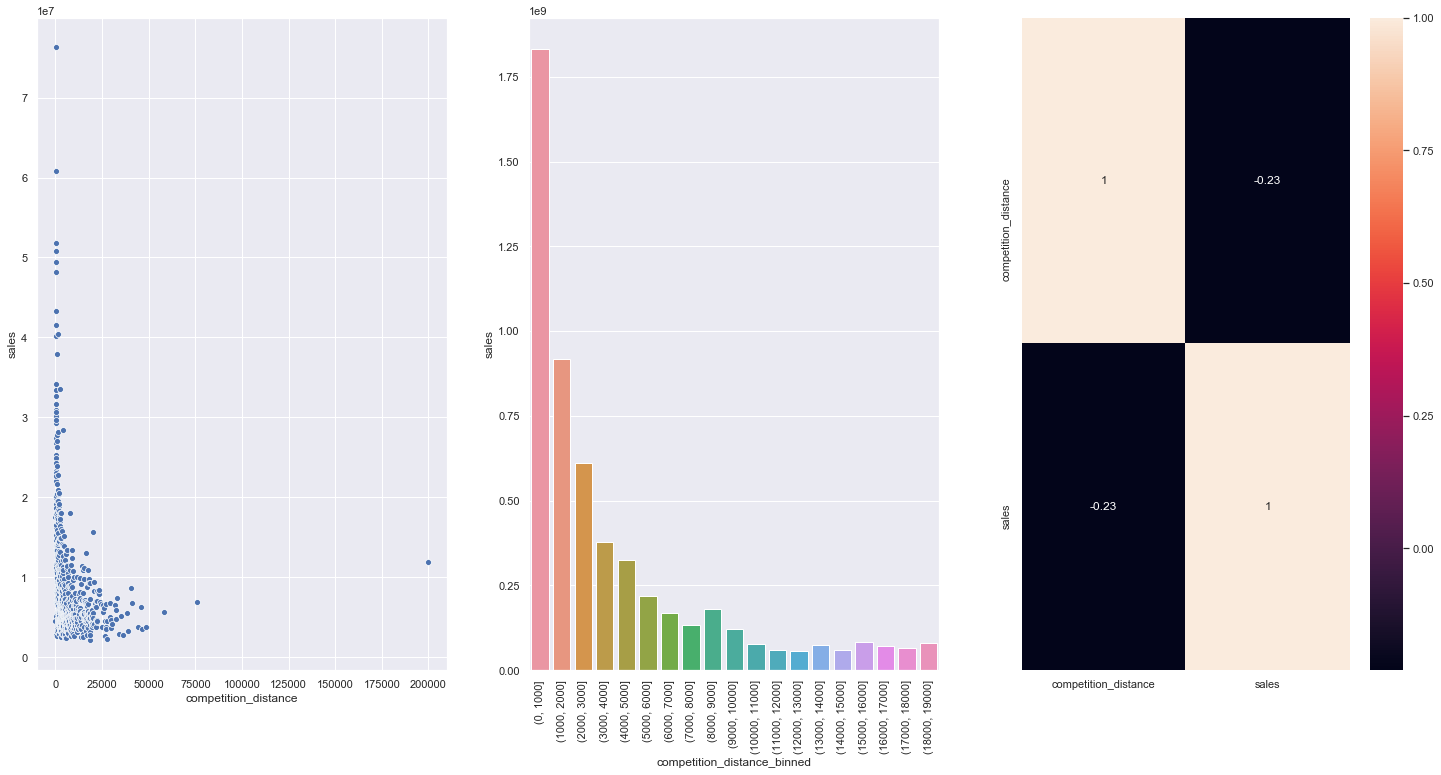

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);


plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);

# bottom, top= x.get_ylim()
# x.set_ylim(bottom+0.5, top-0.5);

Chocamos a crença do time de negócios: as vendas aumentam conforme os concorrentes são próximos. Podemos pensar numa possibilidade macroeconomomica do tipo em que, quanto mais lojam próximas vendem o mesmo tipo de produto, maior será a compra pelos consumidores.

In [38]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
639,32330.0000,5871619,NaN
262,3300.0000,5068030,"(3000.0, 4000.0]"
611,22330.0000,8269484,NaN
326,4510.0000,8533841,"(4000.0, 5000.0]"


### **H3.** Stores with longer competitors should sell more.
**FALSE**: Stores with **longer competitors** sell **LESS**.

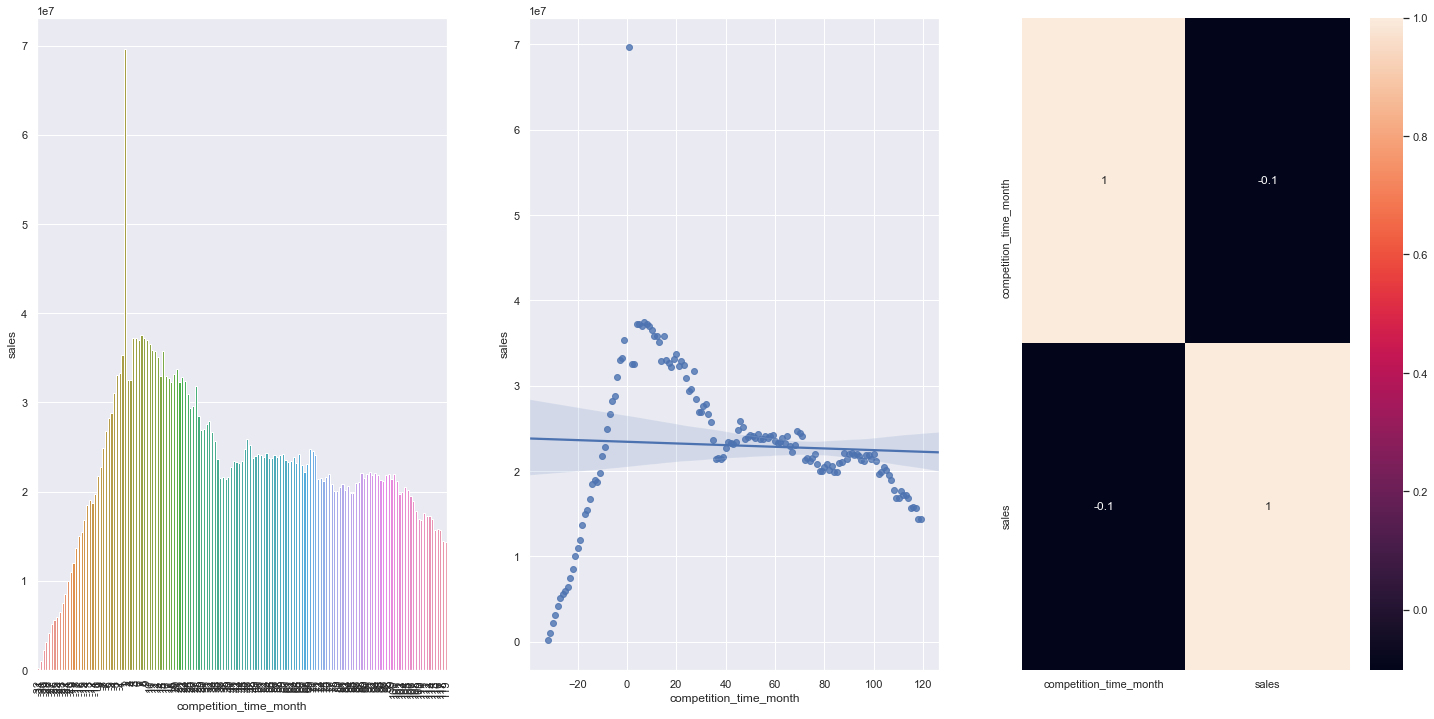

In [39]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);


plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Stores with longer active promotions should sell more.
**FALSE**: Stores with **longer active promotions** sell **LESS** after a certain period of promotion.

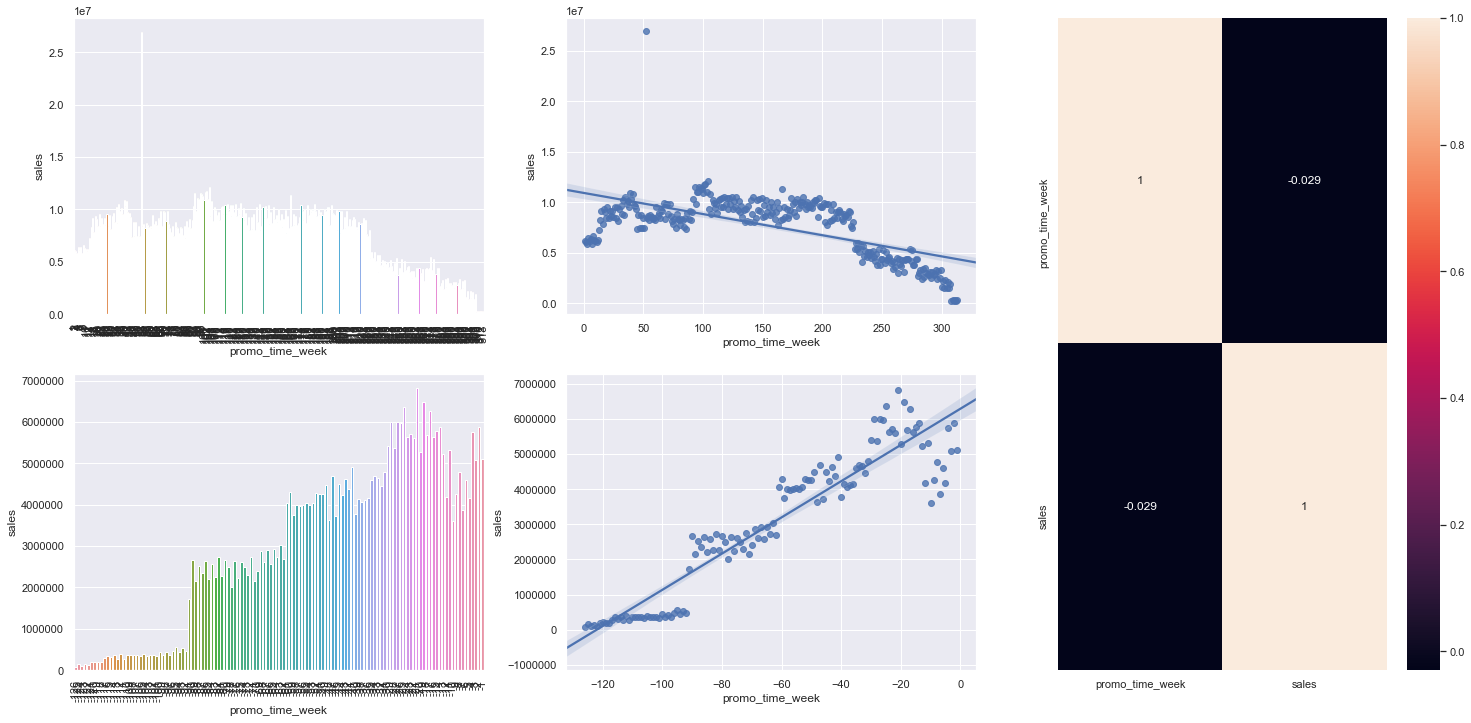

In [40]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)



#### Extended Promotion ####
# plt.subplot(2, 2, 1)
plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
sns.barplot ( x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

# plt.subplot(2, 2, 2)
plt.subplot(grid[0, 1])
sns.regplot( x='promo_time_week', y='sales', data=aux2);


#### Regular Promotion ####
# plt.subplot(2, 2, 3)
plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo
sns.barplot ( x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);


# plt.subplot(2, 2, 4)
plt.subplot(grid[1, 1])
sns.regplot( x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**H5.** Stores with more promotion days should sell more.</s>


### **H6.** Stores with more consecutive promotions should sell more.
**FALSE**: Stores with **more consecutive promotions** sell **LESS**.

In [41]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values(by='sales', ascending=True).reset_index()

,promo,promo2,sales
0,0,1,1289362241
1,1,1,1472275754
2,0,0,1482612096
3,1,0,1628930532


Podemos observar que não há uma grande vantagem em participar de uma promoção extendida.

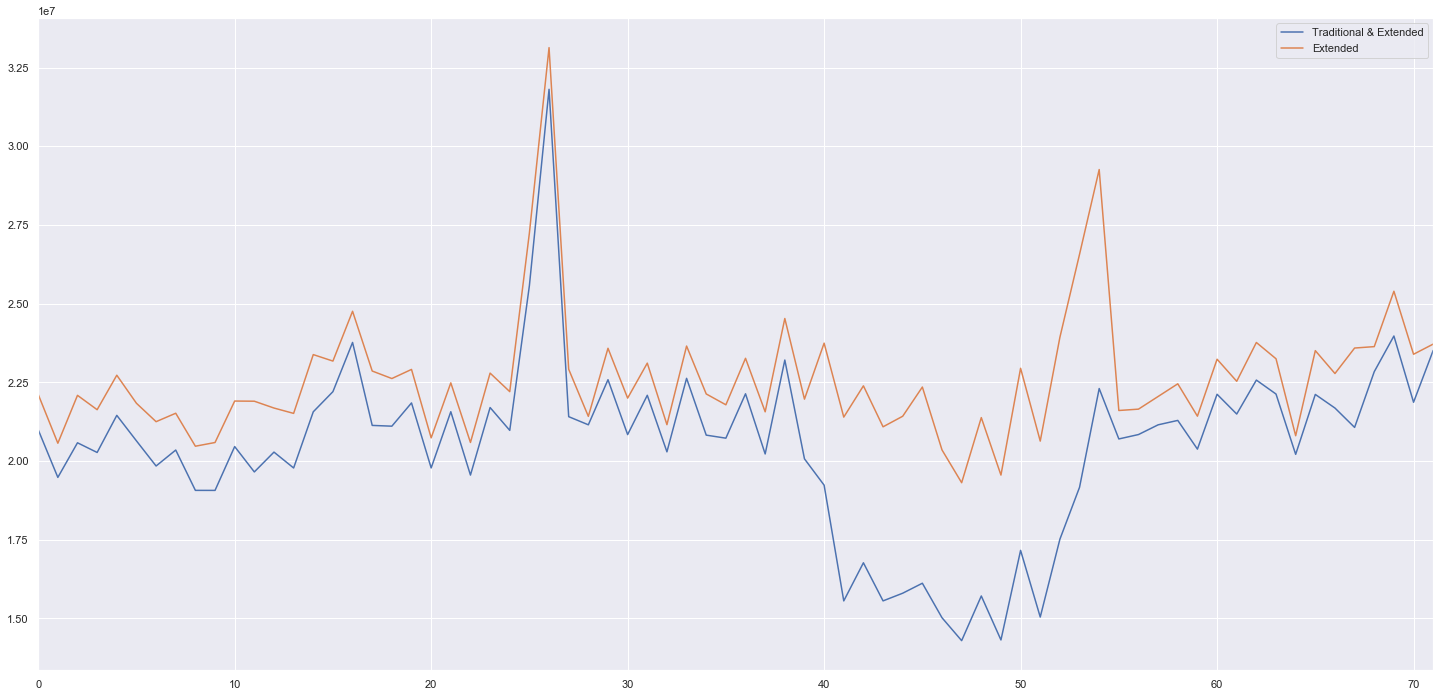

In [42]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional & Extended', 'Extended']);

### **H7.** Stores open during the Christmas holiday should sell more.
**FALSE**: Stores open during the **Christmas holiday** sell **LESS**.

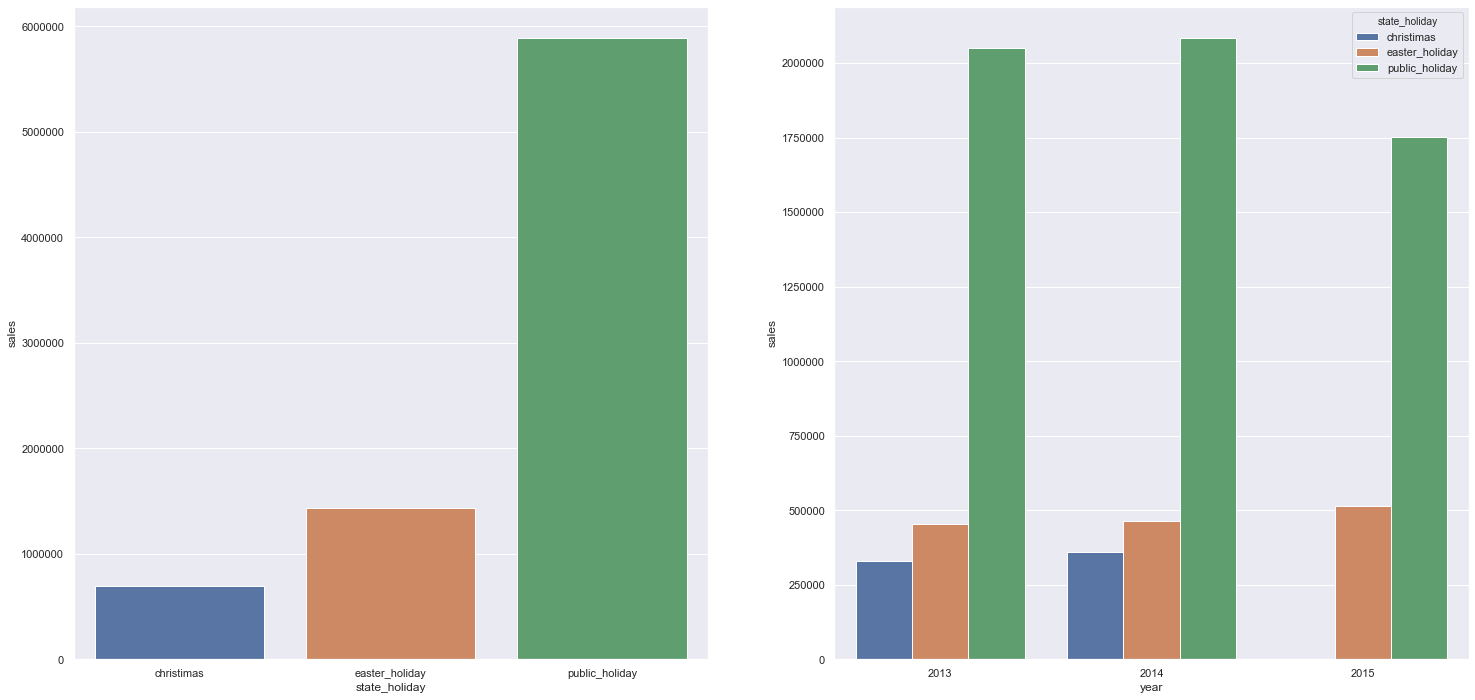

In [43]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);


plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Stores should sell more over the years.
**FALSE**: Stores sell less over the years.

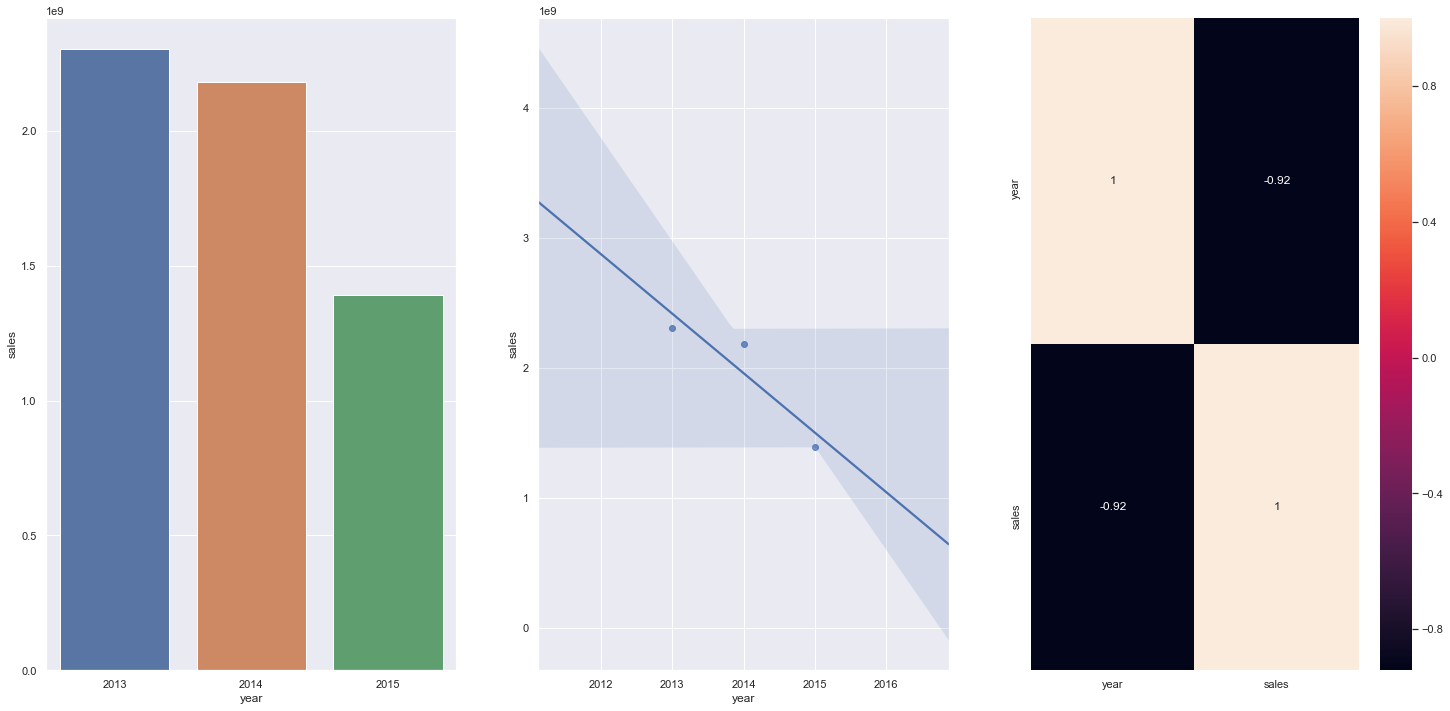

In [44]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);


### **H9.** Stores should sell more in the second semester of the year.
**FALSE**: Stores sell less in the second half of the year.

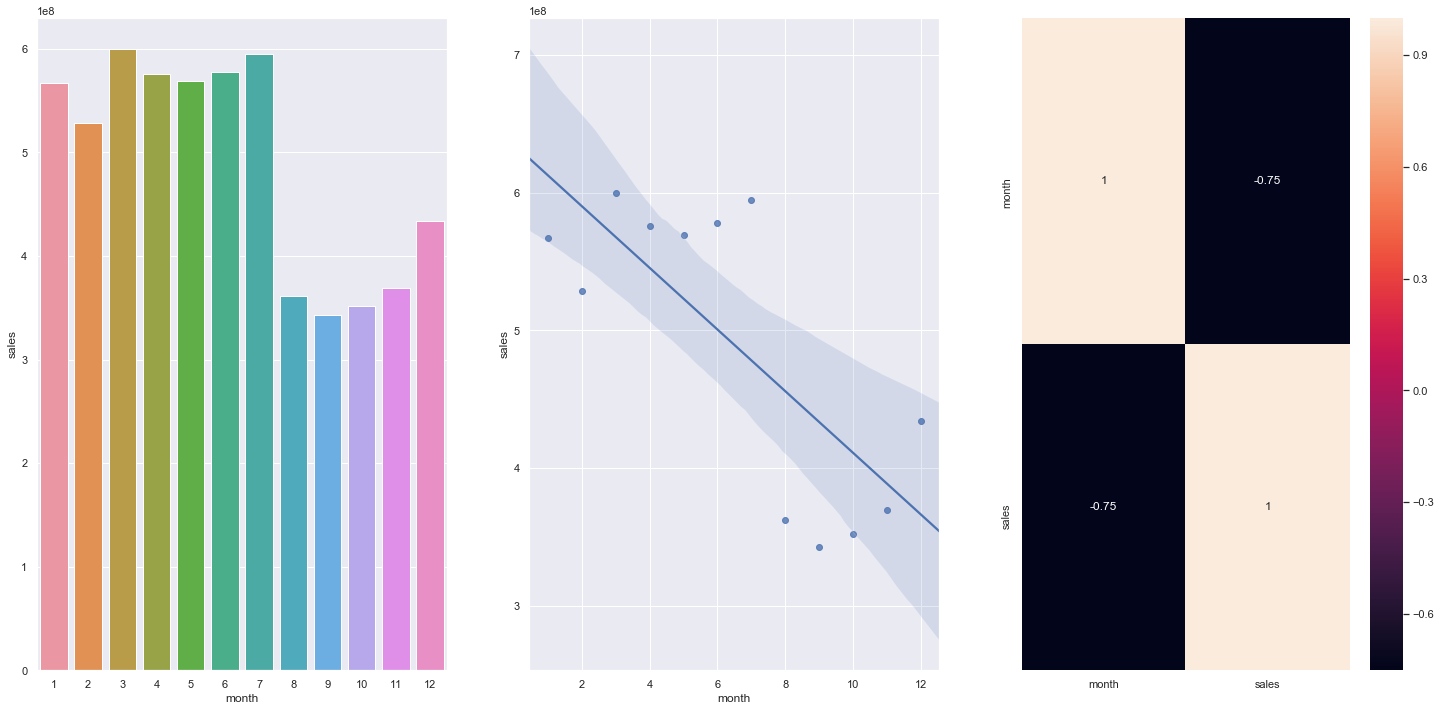

In [45]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### **H10.** Stores should sell more after the 10th day of each month.
**TRUE**: Stores sell **MORE** after the **10th** of each month.

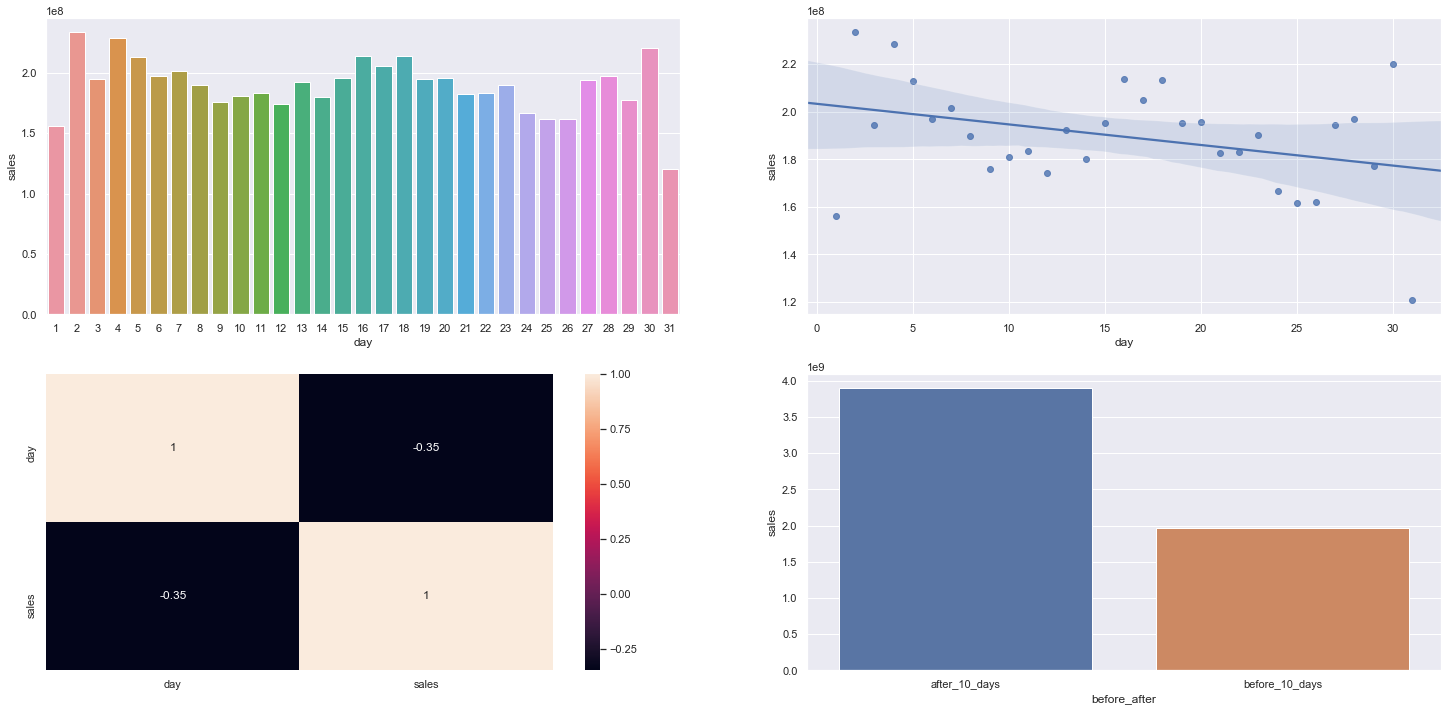

In [46]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(), annot=True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
plt.subplot(2, 2, 4)
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Stores should sell less on weekends.
**TRUE**: Stores sell **LESS** on weekends.

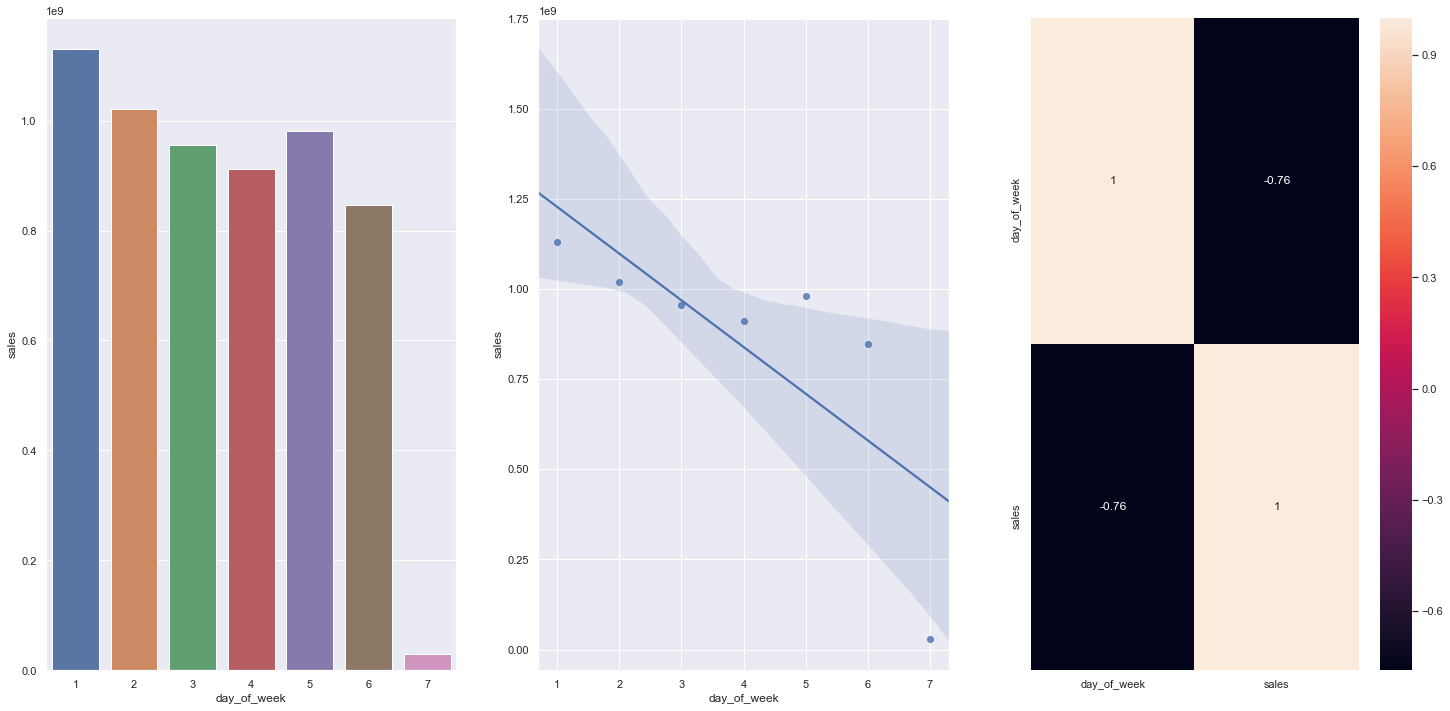

In [47]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

### **H12.** Stores should sell less during school holidays.
**TRUE**: Stores sell **LESS** during school holidays (except for July and August).

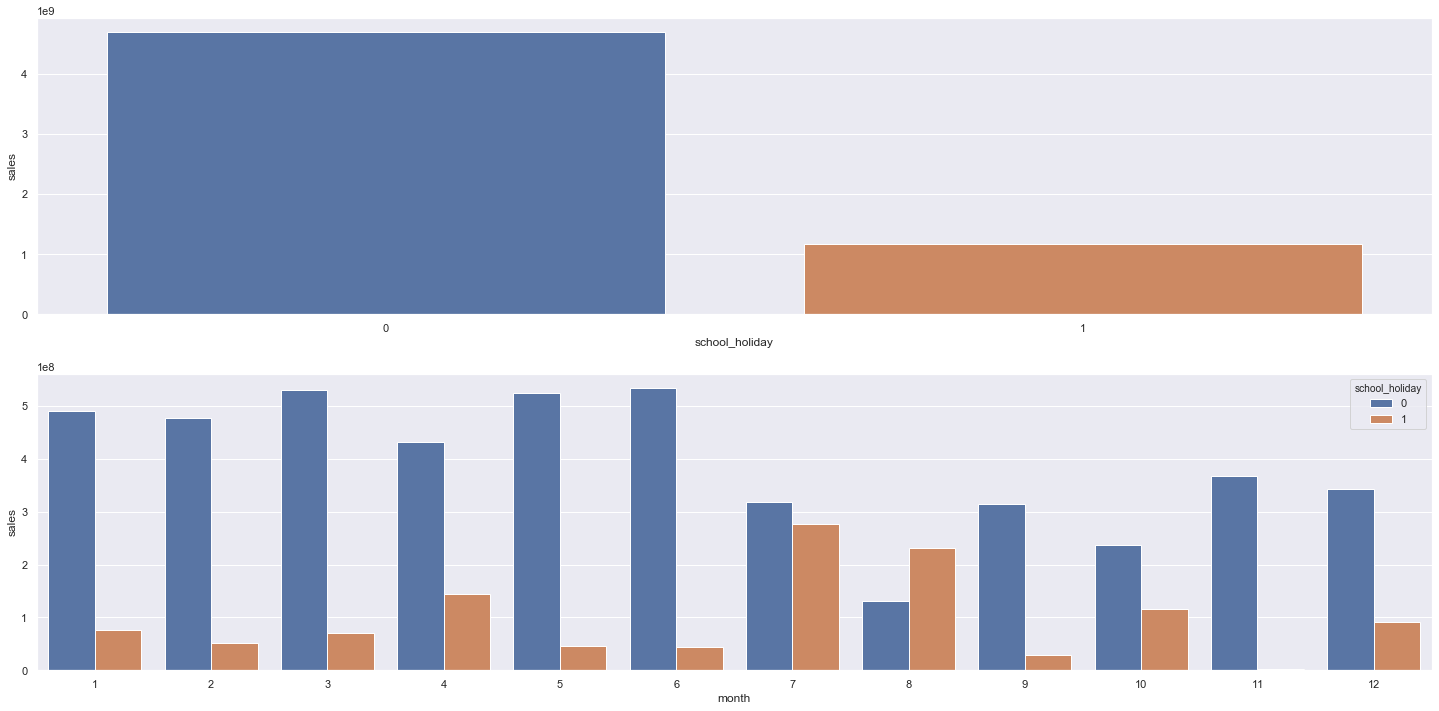

In [48]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Hypothesis Resume

In [49]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low']
]
print (tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

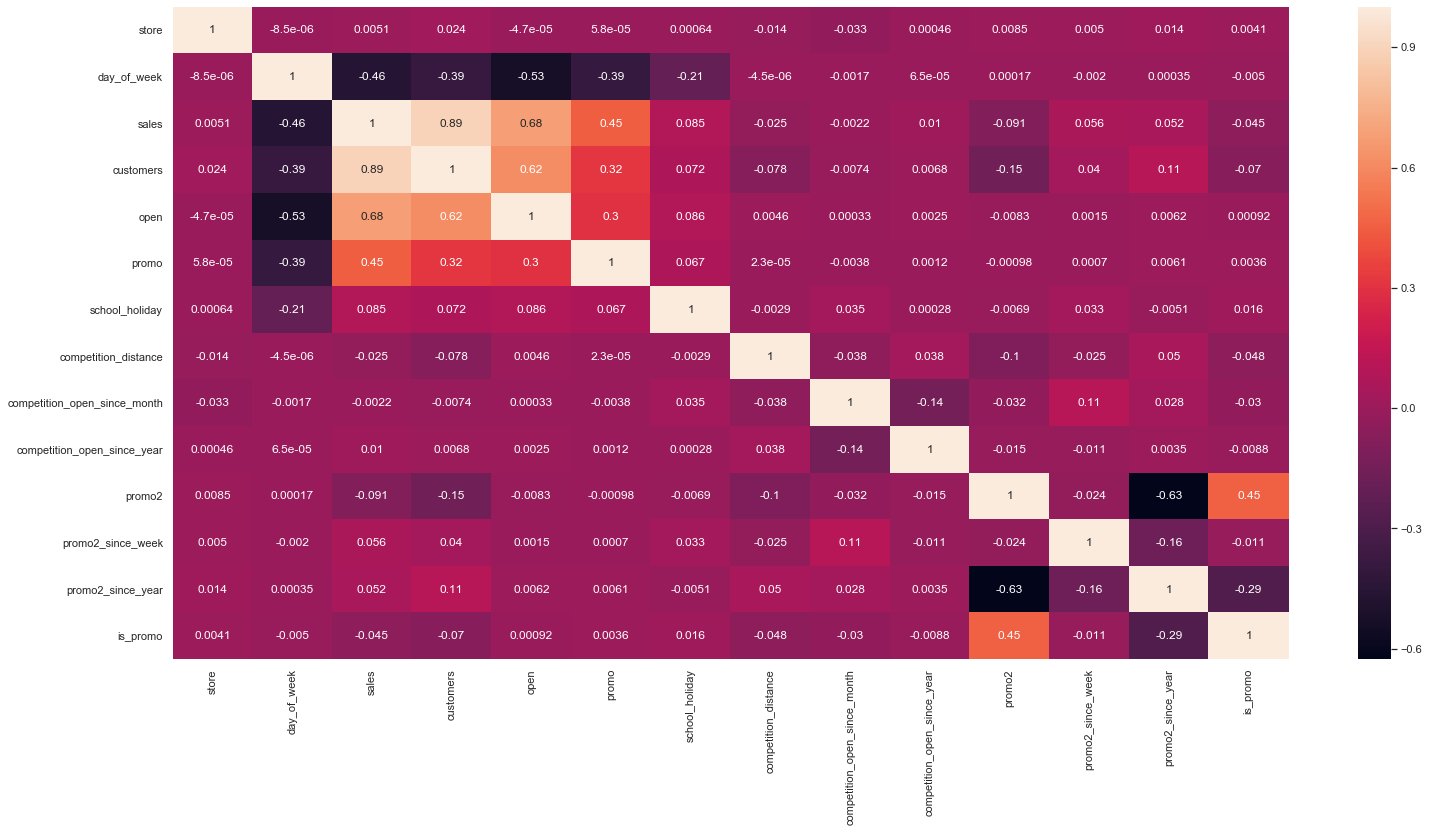

In [50]:
correlation = num_attributes.corr()
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

In [51]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [52]:
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [53]:
def cramer_v(x, y):
    """measure of association between two nominal variables, made by user"""
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    phi2 = chi2/n
    min_d = min(k-1, r-1)
    
    V = np.sqrt(phi2 / (min_d))
    
    
    phi2corr = max(0, phi2 - ((k-1)*(r-1)/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    min_dcorr = min(kcorr-1, rcorr-1)
    
    Vcorr = np.sqrt(phi2corr / (min_dcorr))
    
    return Vcorr

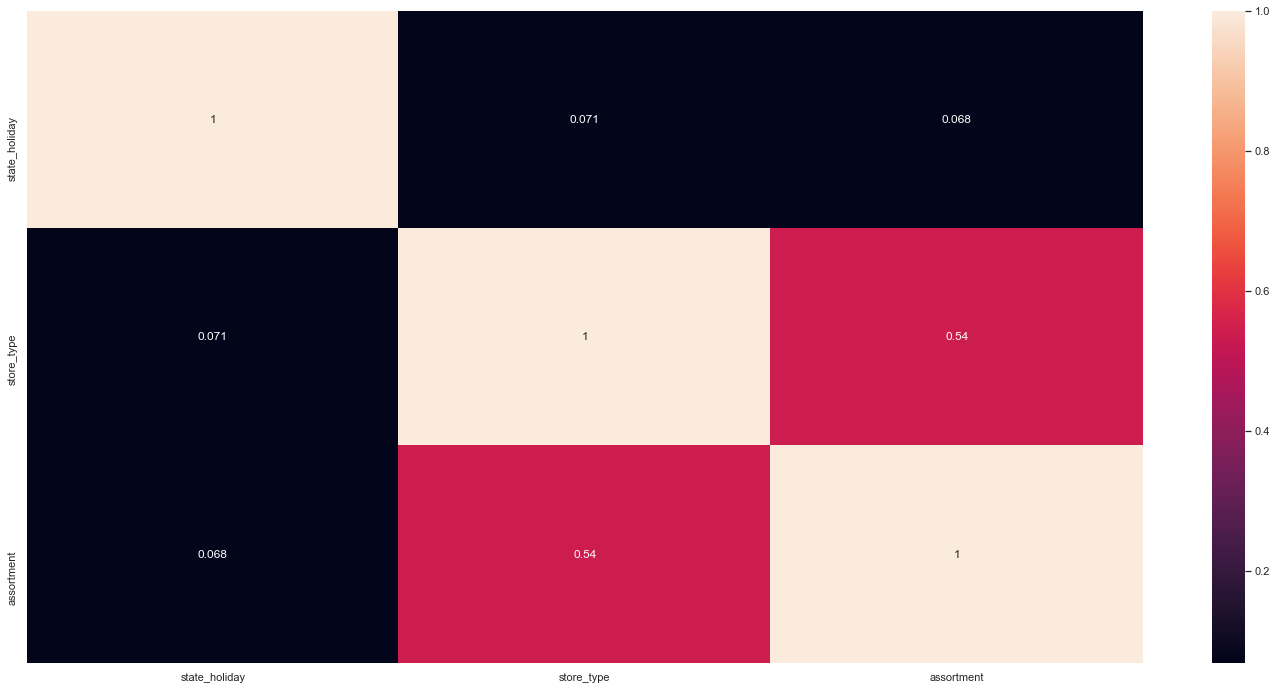

In [54]:
# Calculate Cramer's V

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0. DATA PREPARATION

In [55]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling

In [56]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance']= rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month']= rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week']= mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year']= rs.fit_transform(df5[['year']].values)

## 5.3. Transforming

### 5.3.1. Encoding

In [57]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                    'extra':2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [58]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [59]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x* (2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x* (2.*np.pi/7)))


# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2.*np.pi/12)))


# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x* (2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x* (2.*np.pi/30)))


# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x* (2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x* (2.*np.pi/52)))

In [60]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christimas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.5686,1,1,2,1,-0.1710,9,2008,0,31,2015,0,1.0000,7,31,31,2015-30,2008-09-01,0.9189,2015-07-27,0.2870,0,0,0,1,-0.9749,-0.2225,-0.5000,-0.8660,0.2079,0.9781,-0.5681,-0.8230
1,2,5,2015-07-31,8.7103,1,1,0,1,-0.2839,11,2007,1,13,2010,1,1.0000,7,31,31,2015-30,2007-11-01,1.0541,2010-03-22,0.9226,0,0,0,1,-0.9749,-0.2225,-0.5000,-0.8660,0.2079,0.9781,-0.5681,-0.8230
2,3,5,2015-07-31,9.0258,1,1,0,1,1.9032,12,2006,1,14,2011,1,1.0000,7,31,31,2015-30,2006-12-01,1.2027,2011-03-28,0.8018,0,0,0,1,-0.9749,-0.2225,-0.5000,-0.8660,0.2079,0.9781,-0.5681,-0.8230
3,4,5,2015-07-31,9.5465,1,1,2,3,-0.2758,9,2009,0,31,2015,0,1.0000,7,31,31,2015-30,2009-09-01,0.7432,2015-07-27,0.2870,0,0,0,1,-0.9749,-0.2225,-0.5000,-0.8660,0.2079,0.9781,-0.5681,-0.8230
4,5,5,2015-07-31,8.4812,1,1,0,1,4.4484,4,2015,0,31,2015,0,1.0000,7,31,31,2015-30,2015-04-01,-0.1622,2015-07-27,0.2870,0,0,0,1,-0.9749,-0.2225,-0.5000,-0.8660,0.2079,0.9781,-0.5681,-0.8230


# 6.0. FEATURE SELECTION

In [61]:
df6 = df5.copy()

## 6.1. Dataframe Split - Train & Test Dataset

In [62]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [63]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [64]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [65]:
X_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christimas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
47945,1,2015-06-18,8.4438,1,0,2,1,-0.1710,9,2008,0,25,2015,0,1.0000,0.8919,0.2870,0,0,0,1,-0.4339,-0.9010,0.0000,-1.0000,-0.5878,-0.8090,0.1205,-0.9927
47946,2,2015-06-18,8.5477,1,0,0,1,-0.2839,11,2007,1,13,2010,0,1.0000,1.0270,0.9089,0,0,0,1,-0.4339,-0.9010,0.0000,-1.0000,-0.5878,-0.8090,0.1205,-0.9927
47947,3,2015-06-18,8.9277,1,0,0,1,1.9032,12,2006,1,14,2011,0,1.0000,1.1892,0.7882,0,0,0,1,-0.4339,-0.9010,0.0000,-1.0000,-0.5878,-0.8090,0.1205,-0.9927
47948,4,2015-06-18,9.0917,1,0,2,3,-0.2758,9,2009,0,25,2015,0,1.0000,0.7297,0.2870,0,0,0,1,-0.4339,-0.9010,0.0000,-1.0000,-0.5878,-0.8090,0.1205,-0.9927
47949,5,2015-06-18,8.5021,1,0,0,1,4.4484,4,2015,0,25,2015,0,1.0000,-0.1892,0.2870,0,0,0,1,-0.4339,-0.9010,0.0000,-1.0000,-0.5878,-0.8090,0.1205,-0.9927


In [66]:
# training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor()

# Define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. Best Features from Boruta

In [67]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [68]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']
    

# columsn to add
feat_to_add = ['date', 'sales']

# final features
# cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. MACHINE LEARNING MODELING

In [69]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [70]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()


# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.8004,0.4551,1835.1355


## 7.2. Linear Regression Model

In [71]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.0898,0.2927,2671.0492


### 7.2.1. Linear Regression Model - Cross Validation

In [77]:
kfold = 5
model_name = 'Linear Regression'
model = lr

lr_result_cv = cross_validation(x_training, kfold, model_name, model, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [78]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.7049,0.2891,2744.4517


### 7.3.1. Lasso - Cross Validation

In [79]:
kfold = 5
model_name = 'Lasso'
model = lrr

lrr_result_cv = cross_validation(x_training, kfold, model_name, model, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [80]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)
# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.6228,0.1000,1011.1916


### 7.4.1. Random Forest Regressor - Cross Validation

In [81]:
kfold = 5
model_name = 'Random Forest Regressor'
model = rf

rf_result_cv = cross_validation(x_training, kfold, model_name, model, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36


## 7.5. XGBoost Regressor

In [82]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             n_jobs=-1,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)
# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,857.8095,0.1251,1260.2089


### 7.5.1. XGBoost Regressor - Cross Validation

In [83]:
kfold = 5
model_name = 'XGBoost Regressor'
model = model_xgb

xgb_result_cv = cross_validation(x_training, kfold, model_name, model, verbose=True)
xgb_result_cv


KFold Number: 5


E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 4


E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 3


E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 2


E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 1


E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
E:\Repos\ds_em_producao\ds_em_producao\dsemprod\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1039.91 +/- 186.68,0.14 +/- 0.02,1496.16 +/- 258.53


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [84]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.6228,0.1000,1011.1916
0,XGBoost Regressor,857.8095,0.1251,1260.2089
0,Average Model,1354.8004,0.4551,1835.1355
0,Linear Regression,1867.0898,0.2927,2671.0492
0,Linear Regression - Lasso,1891.7049,0.2891,2744.4517


*We can observe that the problem is quite complex: linear models do not work very well with this type of model. In addition, both Random Forest and XGBoost worked well with the model, with a slight advantage for Random Forest when it comes to the RMSE.*

But this cannot be treated as our final answer: the period chosen to perform the test may be influencing the result. We need to measure performance over various time intervals on the total dataset.
This technique is called **cross-validation.**

### 7.6.2. Real Performance - Cross Validation

In [88]:
modeling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modeling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36
0,XGBoost Regressor,1039.91 +/- 186.68,0.14 +/- 0.02,1496.16 +/- 258.53
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
